# Lecture 4
We will now look at ways to run a computational process and monitor it as it performs the assigned task. At some moment our algorithm will decide that solution progressed enough to make some decision and will restart it with parameters changed according to what we programmed. The task itself, the communication and the process will vary greatly from case to case, but in general we will need to:
* Start an external application with proper command line arguments.
    * This can be done either in a blocking (the thread serving our Python console will not be accessible, and will lock for the execution of the called program)
    * Or in a nonblocking way, by spawning a separate process to deal with the problem, while our Python console will return control for us to perform various tasks.
* Read data from a file to which the program stores the interesting value.
* Modify settings of the program, either via command line arguments or a setting file.
* Make decisions on what to do next.

**Note**: I use more less this approach to (attempt) track the edge that possibly exists between the laminar and turbulent solution, by iteratively changing perturbation applied to the flow end examining its evolution in time, on the way deciding if the flow is going turbulent or not. The process is very much like trying to push the ball to land on the top of a hill, push it to hard and it passes to the other side, be to gentle and it will not reach the top. But in an infinite number of dimensions (before discretization).

## The model program
For a given task you will need to use a specific program. For me this is a flow solver, for you it might be ANSYS or ADAMS or something completely different. For the purpose of this presentation we will use a simple C++ program, attached to this repository. (This might not be working with MyBinder though). This program:
* stores a random value from a selected range to a file - our data.
* accepts some simple command line arguments.
* Reads a simplistic setting file.
* The source is in the tick-tick folder.

## Use `os.system` call
We start by simply calling the system command, in our case it is our program. To do this we need to import `os` module:

In [1]:
import os

In [2]:
ls

'Lecture 4.ipynb'   tick-tick/


Our test program will be a simple program. The source is given here for the sake of completeness:

In [ ]:
cat ./tick-tick/main.cpp

We start with the simple call to `os.system`. OS is a module that lets our Python script interact with the operating system, and the `system()` method executes the command (a string) in a subshell. It is a blocking call, meaning for the time of execution the console is unusable.

In [4]:
os.system('./tick-tick/build_debug/tick-tick')
# os.system('./tick-tick/build_debug/tick-tick --period 10')

===== Starting process =====
Period:1000
Dt:	0.1
Xmax:	1
Xmin:	-1
N:	10


0

In [5]:
ls

 data.dat  'Lecture 4.ipynb'   tick-tick/


This executes `tick-tick` program, the working directory (place where work is performed is) is the same as our current working directory. As a result `data.dat` should appear. The file content is:

In [6]:
cat data.dat

# Recording precious random data
# t, value
# Settings: 1000 0.1 1 -1 10
0,	 -0.736924
0.1,	 -0.0826997
0.2,	 -0.562082
0.3,	 0.357729
0.4,	 0.869386
0.5,	 0.0388327
0.6,	 -0.930856
0.7,	 0.0594004
0.8,	 -0.984604
0.9,	 -0.866316


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')

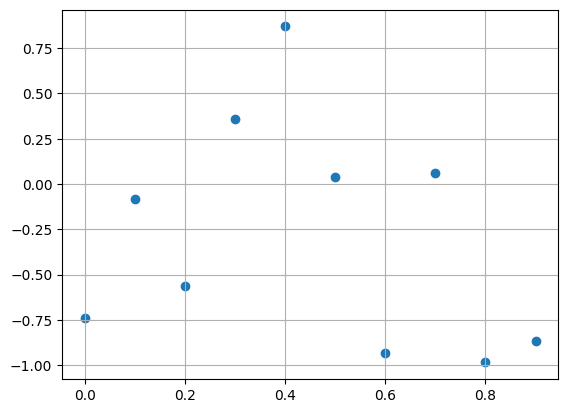

In [9]:
plt.scatter(t, v)
plt.grid()

Before proceeding lets add setting file we can manipulate:

In [10]:
f = open('./settings', 'w')
f.writelines('DT   = 0.5\n')
f.write('XMAX = 5.0\n')
f.write('XMIN = -5.0\n')
f.write('N    = 1000\n')
f.close()

In [12]:
ls

 data.dat  'Lecture 4.ipynb'   settings   tick-tick/


In [11]:
cat settings

DT   = 0.5
XMAX = 5.0
XMIN = -5.0
N    = 1000


Now we have a settings file to be passed to our process.

In [16]:
os.system('./tick-tick/build_debug/tick-tick --period 10 --sett settings')

===== Starting process =====
Period:10
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	1000


0

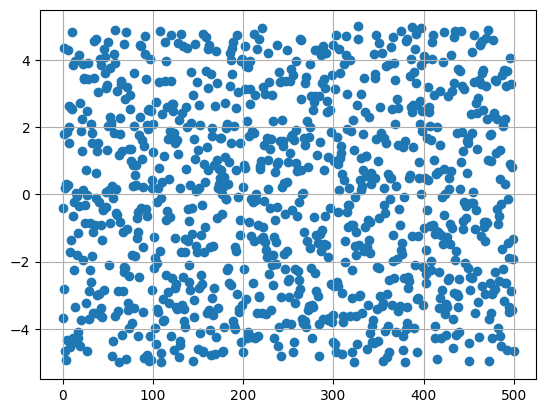

In [14]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

## `subprocess`
### Blocking call:
Ultimately we would like to run the program and regain control, while the program runs. To this end we will use the `subprocess` module and a couple of `os` tools. The `subprocess` module allows to create new processes, obtain their returns and outputs. We will show only some of the functionality. Let's start with getting the output with `check_output`, that we can later parse and use:

In [17]:
import subprocess

In [18]:
ls -l

total 136
-rw-rw-r-- 1 sgepner sgepner  15482 kwi  3 16:43  data.dat
-rw-rw-r-- 1 sgepner sgepner 110654 kwi  3 16:45 'Lecture 4.ipynb'
-rw-rw-r-- 1 sgepner sgepner     46 kwi  3 16:40  settings
drwxrwxr-x 5 sgepner sgepner   4096 kwi  3 12:02  tick-tick/


In [20]:
s = subprocess.check_output(["ls", "-l"])
# print(s)
for ss in s.splitlines():
    print(ss)

b'total 136'
b'-rw-rw-r-- 1 sgepner sgepner  15482 kwi  3 16:43 data.dat'
b'-rw-rw-r-- 1 sgepner sgepner 110654 kwi  3 16:45 Lecture 4.ipynb'
b'-rw-rw-r-- 1 sgepner sgepner     46 kwi  3 16:40 settings'
b'drwxrwxr-x 5 sgepner sgepner   4096 kwi  3 12:02 tick-tick'


For us, more useful is `call()`. It runs command passed as argument and waits (locks control) until command completes. 

In [21]:
subprocess.call("tick-tick/build_debug/tick-tick --period 50 --sett settings", shell=True)

===== Starting process =====
Period:50
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	1000


0

Note the additional `shell=True` argument. This specifies that the command will be executed through the system shell (eg. Bash) and is useful if we need to pass arguments. We can illustrate the result:

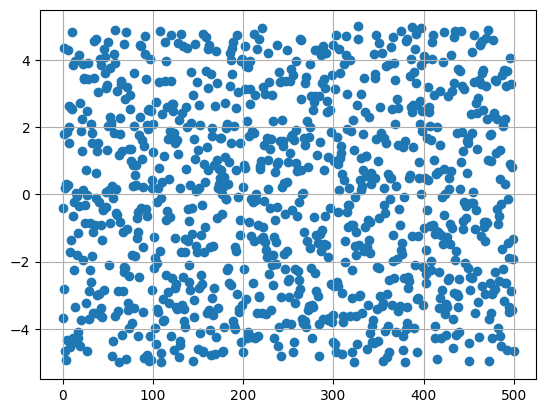

In [22]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

Example: Using the `tick-tick` program and the `call` function write a script that runs the `tick-tick` changing the number of iterations N and plots average and variance as functions of N.

1. Write a function that modifies the setting file accordingly.
2. Write a function that reads the result file and stores the results.
3. Run the process in a loop, choose some stopping criteria.

In [23]:
def settfile(fname, N):
    '''
    Modifies the setting file
    param: fname - file to modify
    param: N - nuber of iteration do perform
    '''
    f = open(fname, 'w')
    f.writelines('DT   = 0.5\n')
    f.write('XMAX = 5.0\n')
    f.write('XMIN = -5.0\n')
    st =    'N    = ' + str(N) + '\n'
    f.write(st)
    f.close()

In [24]:
def calculate(fname):
    '''
    Using fname calculates average and variance
    '''
    t, v = np.loadtxt(fname, comments="#", skiprows=3, usecols=(0,1), unpack=True, delimiter=',')
    s = v.sum()
    avg = s / len(t)
    s = 0
    for val in v:
        s += (val - avg)**2
    var = s / len(t)
    return avg, var

In [30]:
'''
Run the process here
'''
n = []
av = []
va = []
for N in range(5,10000,50):
    st = 'settings'
    settfile(st, N)
#     print('Running for N=', N)
    subprocess.call("tick-tick/build_debug/tick-tick --period 0 --sett settings", shell=True)
    a, v = calculate('data.dat')
    n.append(N)
    av.append(a)
    va.append(v)
#     print(a, v)

===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	5
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	55
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	105
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	155
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	205
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	255
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	305
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	355
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	405
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	455
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	505
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	555
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	605
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	655
===== Starting process 

===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	5805
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	5855
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	5905
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	5955
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6005
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6055
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6105
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6155
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6205
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6255
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6305
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6355
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6405
===== Starting process =====
Period:0
Dt:	0.5
Xmax:	5
Xmin:	-5
N:	6455
===== 

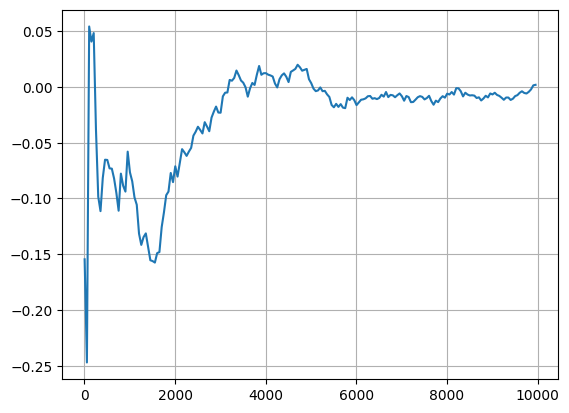

In [31]:
plt.plot(n, av)
plt.grid()

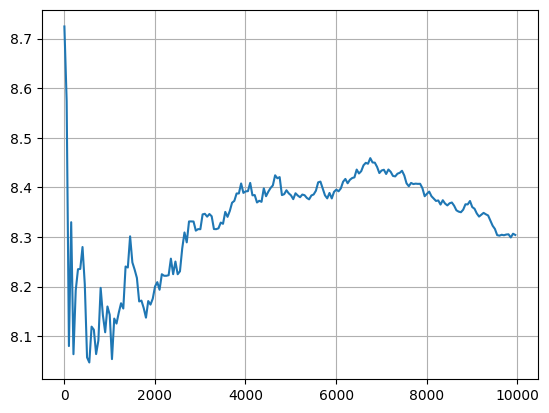

In [32]:
plt.plot(n, va)
plt.grid()

### Run and regain control with `popen()`
We will now look at a slight modification. Our goal is to be able to monitor (programmatically) the process we call and if necessary make decision, change parameters and eventually stop execution or restart. To do this we need to add a couple of things to our tool set. Fist is the `subprocess.Popen()`, which works very much like `call()`, with a difference that it executes the child (mercy!) in a new process! What that means is that new, separate from our Python interpreter, process is started to handle the program, and control is returned to the interpreter to perform whatever task we wish it to do. When called `Popen` object is returned. We will outline some of functionality it provides (also see the documentation).

**The most important feature is that `Popen()` allows a nonblocking call!**

In [33]:
import subprocess

Note: It is good to show the process tree at this moment.

In [44]:
p=subprocess.Popen('tick-tick/build_debug/tick-tick --period 500 --sett settings', shell=True)

`p` is going to be a `Popen` with which we (or our smart algorithm) can interact. There is a number of things we could do. The most important is to check if the child process is alive (`Popen.poll()`), wait for it to finish with (`Popen.wait(timeout)`), or send it a signal for termination or kill (`Popen.terminate() .kill()`). There is also an option to interact with the process passing data to `stdin` and to read from `stdout` with `Popen.communicate()`, but our program does not support this (you can try it out).

Examine:
* `p.poll()`
* `p.wait()`
* `p.pid`
* `p.terminate()` and `p.kill()`

In [39]:
print(p)

<Popen: returncode: None args: 'tick-tick/build_debug/tick-tick --period 500...>


In [51]:
p.terminate()

In [52]:
try:
    print(p.wait(timeout=10))
except:
    print('some error!')

-15


In [53]:
print(p.returncode)

-15


In [54]:
print(p.pid)

1749604


In [56]:
cat data.dat

# Recording precious random data
# t, value
# Settings: 500 0.5 5 -5 9955
0,	 -3.68462
0.5,	 -0.413499
1,	 -2.81041
1.5,	 1.78865
2,	 4.34693
2.5,	 0.194164
3,	 -4.65428
3.5,	 0.297002
4,	 -4.92302
4.5,	 -4.33158
5,	 1.86773
5.5,	 4.30436
6,	 0.269288
6.5,	 1.53919
7,	 2.01191
7.5,	 2.62198
8,	 -4.52535
8.5,	 -1.71766
9,	 2.5641
9.5,	 -1.34661
10,	 4.8255
10.5,	 2.53356
11,	 -4.27314
11.5,	 3.84707
12,	 -0.635886
12.5,	 -0.222682
13,	 -2.25093
13.5,	 -3.33493
14,	 3.97656
14.5,	 -4.39436
15,	 0.0452289
15.5,	 -1.80967
16,	 -0.0602331
16.5,	 -4.09267
17,	 -4.26251
17.5,	 -1.15858
18,	 4.13817
18.5,	 -0.355542
19,	 -4.49916
19.5,	 2.70205
20,	 -3.74635
20.5,	 1.88455
21,	 1.29543
21.5,	 2.25412
22,	 3.88572
22.5,	 -1.93678
23,	 0.132737
23.5,	 3.45982
24,	 3.41511
24.5,	 -0.846054
25,	 -0.320826
25.5,	 -3.21672
26,	 0.716548
26.5,	 -4.66946
27,	 -0.0151988
27.5,	 2.48293
28,	 3.90737
28.5,	 3.4204
29,	 -2.87248
29.5,	 -3.69573
30,	 -2.25412
30.5,	 -0.857067
31,	 2.0982
31.5,	 -2.60089
32

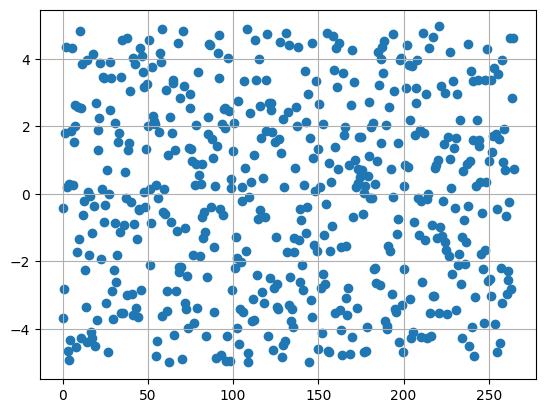

In [57]:
t, v = np.loadtxt('data.dat', comments="#", skiprows=2, usecols=(0,1), unpack=True, delimiter=',')
plt.scatter(t, v)
plt.grid()

In [58]:
import time

In [66]:
'''
Run the process here
'''
p=subprocess.Popen('tick-tick/build_debug/tick-tick --period 10 --sett settings', shell=True)

In [ ]:
nn = []
av = []
while True:
    if p.poll() != None:
        print(p.pid, 'Is not working')
        break
    time.sleep(2)
    
    a, v = calculate('data.dat')
#     nn.append(len(av))
    av.append(a)
    print(len(av), a)
    if np.abs(a) < 1e-5:
        p.terminate()
        print(p.pid, 'is now dead')

plt.plot(nn, av)
plt.grid()

1 -0.022005512676056344
2 -0.07182536234718827
3 -0.07855395130794701
4 -0.08215924530663327
5 -0.06990001019095478
6 -0.12704437709243696
7 -0.1363990532034632
8 -0.143961768399747
9 -0.10639271195272931
10 -0.07915614365618662
11 -0.05490503551199262
12 -0.047431154164198054
13 -0.036853100074276786
14 -0.04033835345315904
15 -0.02714341604272635
16 -0.00688364175198729
17 0.01082886810479042
18 0.006479274199660629
19 0.003463326017153598
20 0.009411742822210916
21 0.01027613877244057
22 0.008660205076424269
23 0.005923203461112341
24 0.02010977209430757
25 0.0161465120146819
26 -0.0054115583294117664
27 -0.0019914636978281457
28 -0.015932669697687123
29 -0.016865312224762573
30 -0.012573162203332192
31 -0.014634295339805824
32 -0.00700789073489559
33 -0.011557510463821878
34 -0.004305506495572562
35 -0.008179022204402968
36 -0.011916409342217174
37 -0.013606452951724132
38 -0.007587126729348546
39 -0.011932985901060069
40 -0.013816790731240428
41 -0.006036333312998007
42 0.00117759